In [2]:
from __future__ import absolute_import, division, print_function
from builtins import *  # @UnusedWildImport

from mcculw import ul
from mcculw.device_info import DaqDeviceInfo
from mcculw.enums import *

try:
    from mcculw.console_examples_util import config_first_detected_device
except ImportError:
    from mcculw.console_examples_util import config_first_detected_device
import numpy as np
from time import perf_counter_ns 
import matplotlib.pyplot as plt
import pandas as pd

import time
import os
import sys
import libtiepie
from tiepie.Tiepie_Examples.printinfo import *
from matplotlib import rc

## BlueBox DAC 

In [2]:
use_device_detection = True
dev_id_list = []
board_num = 0
channel_in= 0
channel_out = 0

In [3]:
config_first_detected_device(board_num, dev_id_list)
daq_dev_info = DaqDeviceInfo(board_num)

Found 1 DAQ device(s):
  USB-1208FS (1667411) - Device ID = 130


In [4]:
ai_info = daq_dev_info.get_ai_info()
ao_info = daq_dev_info.get_ao_info()
ao_range = ao_info.supported_ranges[0]

In [5]:
ai_info.supported_ranges

[<ULRange.BIP20VOLTS: 15>,
 <ULRange.BIP10VOLTS: 1>,
 <ULRange.BIP5VOLTS: 0>,
 <ULRange.BIP4VOLTS: 16>,
 <ULRange.BIP2PT5VOLTS: 2>,
 <ULRange.BIP2VOLTS: 14>,
 <ULRange.BIP1PT25VOLTS: 3>,
 <ULRange.BIP1VOLTS: 4>]

In [6]:
print(ao_info.supported_ranges)
print('Max Range: ' +str(ao_range.range_max) + ' V')
print('Min Range: ' +str(ao_range.range_min) + ' V')

[<ULRange.UNI4VOLTS: 114>]
Max Range: 4.0 V
Min Range: 0 V


In [7]:
steps = 4   
output_voltage = np.arange(0, ao_range.range_max + (ao_range.range_max/steps), ao_range.range_max/steps)
print('Output Voltages: ' +str(output_voltage))

Output Voltages: [0. 1. 2. 3. 4.]


In [8]:
ul.v_out(board_num, channel_out, ao_range, output_voltage[2])

In [9]:
value = ul.v_in(board_num, 0, ULRange.BIP20VOLTS)
value

0.576171875

In [10]:
n=0
ul.v_out(board_num, channel_out, ao_range, output_voltage[n])
time_p_voltage = 0.5; time_p_voltage_updated = time_p_voltage; 
total_time_measurement = time_p_voltage * len(output_voltage) 
time = 0; time_recording = [time]; voltage_recording = [n]
time_zero = perf_counter_ns()
while time < total_time_measurement:
    if time > time_p_voltage_updated:
        #print('before: ' + str(time_p_voltage))
        #print('n before: ' + str(n))

        n = n+1
        ul.v_out(board_num, channel_out, ao_range, output_voltage[n])
        time_p_voltage_updated = time_p_voltage * (n+1)
        #print('after: ' + str(time_p_voltage_updated))
        #print('n after: ' + str(n))

        #print('')
    
    value = ul.v_in(board_num, 0, ULRange.BIP20VOLTS)
    time = (perf_counter_ns()-time_zero) * (10**(-9))
    voltage_recording = np.append(voltage_recording,value)
    time_recording = np.append(time_recording,time)  

Text(0.5, 1.0, '\\textbf{Blue Box Voltage Steps: Voltage Increase of 1 V per Step $\\mathrm{\\vert}$ Pins input 1 \\& 13 output}')

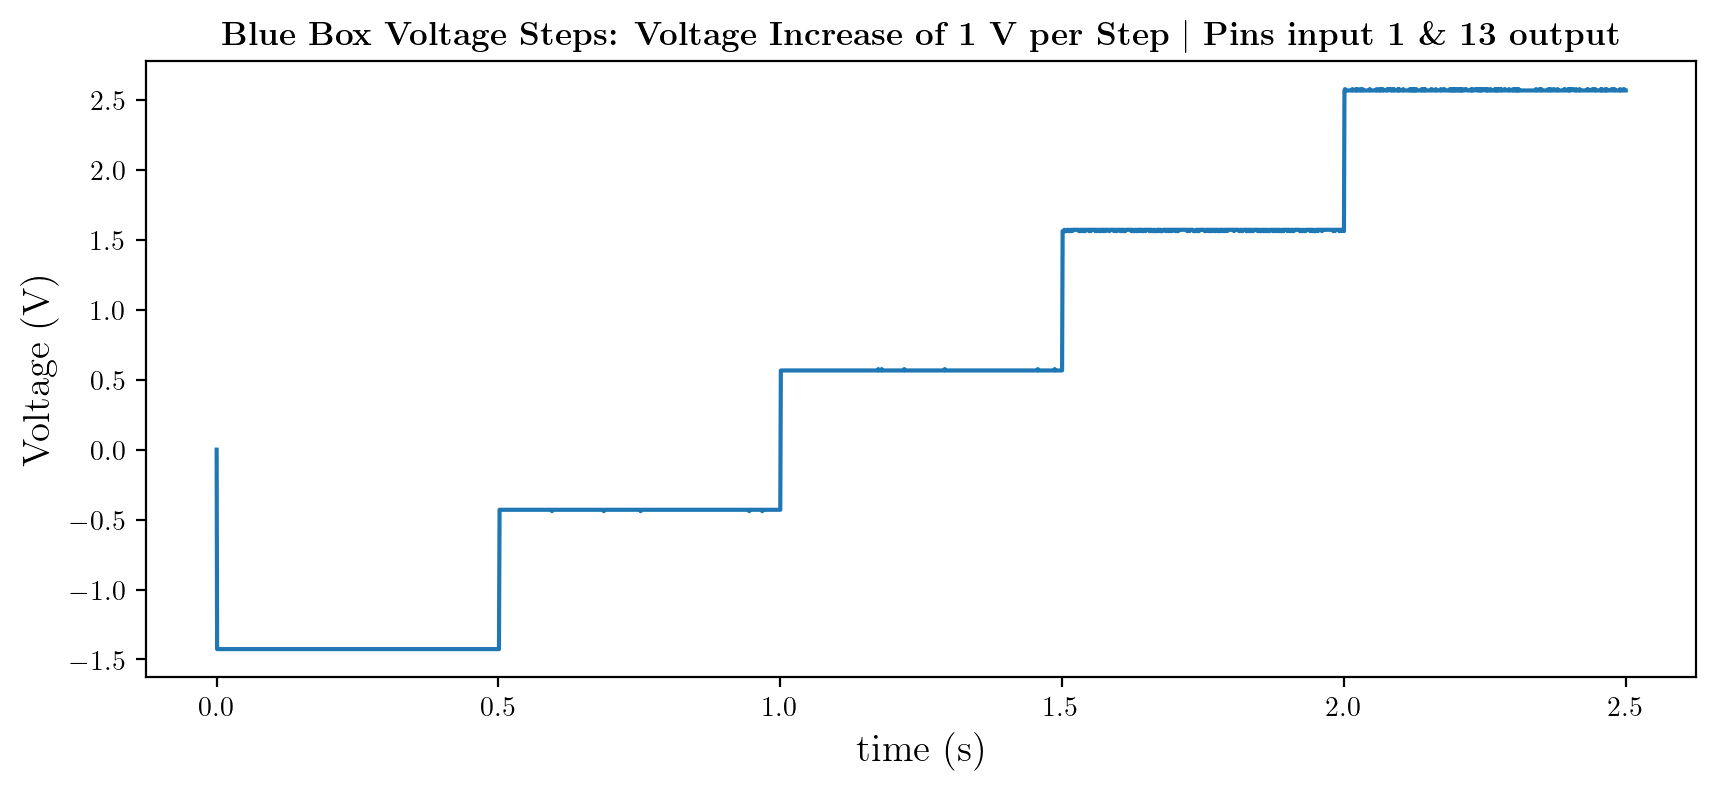

In [31]:
rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(10, 4), dpi=200)
plt.plot(time_recording, voltage_recording)
plt.xlabel(r'time (s)', fontsize=14) 
plt.ylabel(r'Voltage (V)', fontsize=14)
plt.title(r'\textbf{Blue Box Voltage Steps: Voltage Increase of 1 V per Step $\mathrm{\vert}$ Pins input 1 \& 13 output}')


In [12]:
ul.release_daq_device(board_num)

## Tiepie

In [4]:
print_library_info()

# Enable network search:
libtiepie.network.auto_detect_enabled = True

# Search for devices:
libtiepie.device_list.update()

if len(libtiepie.device_list) > 0:
    print()
    print('Available devices:')

    for item in libtiepie.device_list:
        print('  Name: ' + item.name)
        print('    Serial number  : ' + str(item.serial_number))
        print('    Available types: ' + libtiepie.device_type_str(item.types))

        if item.has_server:
            print('    Server         : ' + item.server.url + ' (' + item.server.name + ')')
else:
    print('No devices found!')

exit


Library:
  Version      : 0.9.16.3
  Configuration: 0x7e5aa1d78697bac1390b0b2580dbc623050301433ba0

Available devices:
  Name: Handyscope HS6 DIFF-1000XMSG
    Serial number  : 37071
    Available types: Oscilloscope


In [6]:
tiepie = libtiepie.device_list[0]

In [13]:
og_tp = tiepie._get_types

In [17]:
print_device_info

<function tiepie.Tiepie_Examples.printinfo.print_device_info(dev, full=True)>

In [5]:
# OscilloscopeBlock.py
#
# This example performs a block mode measurement and writes the data to OscilloscopeBlock.csv.
#
# Find more information on http://www.tiepie.com/LibTiePie .



# Print library info:
print_library_info()

# Enable network search:
libtiepie.network.auto_detect_enabled = True

# Search for devices:
libtiepie.device_list.update()

# Try to open an oscilloscope with block measurement support:
scp = None
for item in libtiepie.device_list:
    if item.can_open(libtiepie.DEVICETYPE_OSCILLOSCOPE):
        scp = item.open_oscilloscope()
        if scp.measure_modes & libtiepie.MM_BLOCK:
            break
        else:
            scp = None

if scp:
    try:
        # Set measure mode:
        scp.measure_mode = libtiepie.MM_BLOCK

        # Set sample frequency:
        scp.sample_frequency = 1e6  # 1 MHz

        # Set record length:
        scp.record_length = 10000  # 10000 samples

        # Set pre sample ratio:
        scp.pre_sample_ratio = 0  # 0 %

        # For all channels:
        for ch in scp.channels:
            # Enable channel to measure it:
            ch.enabled = True

            # Set range:
            ch.range = 8  # 8 V

            # Set coupling:
            ch.coupling = libtiepie.CK_DCV  # DC Volt

        # Set trigger timeout:
        scp.trigger_time_out = 100e-3  # 100 ms

        # Disable all channel trigger sources:
        for ch in scp.channels:
            ch.trigger.enabled = False

        # Setup channel trigger:
        ch = scp.channels[0]  # Ch 1

        # Enable trigger source:
        ch.trigger.enabled = True

        # Kind:
        ch.trigger.kind = libtiepie.TK_RISINGEDGE  # Rising edge

        # Level:
        ch.trigger.levels[0] = 0.5  # 50 %

        # Hysteresis:
        ch.trigger.hystereses[0] = 0.05  # 5 %

        # Print oscilloscope info:
        print_device_info(scp)

        # Start measurement:
        scp.start()

        # Wait for measurement to complete:
        while not scp.is_data_ready:
            time.sleep(0.01)  # 10 ms delay, to save CPU time

        # Get data:
        data = scp.get_data()

        # Output CSV data:
        csv_file = open('OscilloscopeBlock_.csv', 'w')
        try:
            csv_file.write('Sample')
            for i in range(len(data)):
                csv_file.write(';Ch' + str(i + 1))
            csv_file.write(os.linesep)
            for i in range(len(data[0])):
                csv_file.write(str(i))
                for j in range(len(data)):
                    csv_file.write(';' + str(data[j][i]))
                csv_file.write(os.linesep)

            print()
            print('Data written to: ' + csv_file.name)

        finally:
            csv_file.close()

    except Exception as e:
        print('Exception: ' + e.message)
        sys.exit(1)

    # Close oscilloscope:
    del scp

else:
    print('No oscilloscope available with block measurement support!')
    exit

exit


Library:
  Version      : 0.9.16.3
  Configuration: 0x7e5aa1d78697bac1390b0b2580dbc623050301433ba0
Device:
  Name                      : Handyscope HS6 DIFF-1000XMSG
  Short name                : HS6D-1000XMSG
  Serial number             : 37071
  Calibration date          : 2020-09-29
  Product id                : 25
  Vendor id                 : 2
  Driver version            : 8.1.9.1
  Firmware version          : 1.1.6.0
  Has battery               : False
Oscilloscope:
  Channel count             : 4
  Connection test           : True
  Measure modes             : Stream, Block
  Measure mode              : Block
  Auto resolution modes     : Disabled, Native only, All
  Auto resolution mode      : Native only
  Resolutions               : 8, 12, 14, 16
  Resolution                : 14
  Resolution enhanced       : False
  Clock outputs             : Disabled, Fixed
  Clock output              : Disabled
  Clock sources             : External, Internal
  Clock source              :

In [6]:
df = pd.read_csv('OscilloscopeBlock_.csv', delimiter=';')  


Text(0.5, 1.0, 'Plot of Ch1')

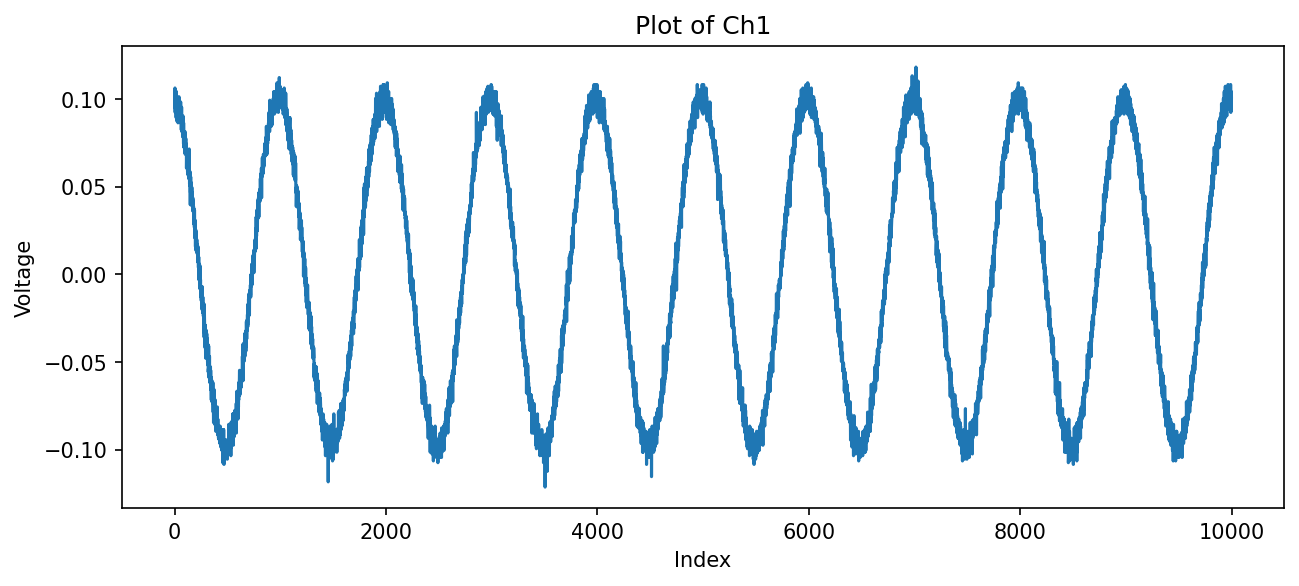

In [8]:
column_to_plot= 'Ch1'
plt.figure(figsize=(10, 4), dpi=150)
plt.plot(df['Sample'], df[column_to_plot])

# Set axis labels and title (customize as needed)
plt.xlabel('Index')
plt.ylabel('Voltage')
plt.title(f'Plot of {column_to_plot}')Salchicha2!

## PROLOGIX and Light Driver ITC 510

In [1]:
#https://docs.python.org/3/library/socketserver.html#socketserver-tcpserver-example

import socket
host_ = '169.254.1.80'
port_ = 1234
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host_,port_))
# Set Address
s.sendall(bytes('++addr 10\n', 'utf-8'))
s.sendall(bytes('++addr\n', 'utf-8'))
received = str(s.recv(1024), 'utf-8')
print('Address ' + received)

Address 10



In [8]:
# Laser Diode Polarity
s.sendall(bytes(':LDPOL?\n', 'utf-8'))
received = str(s.recv(1024), 'utf-8')
print('Laser Diode Polarity ' + received)


Laser Diode Polarity:LDPOL AG



In [9]:
# Laser Diode Polarity
s.sendall(bytes(':MODE?\n', 'utf-8'))
received = str(s.recv(1024), 'utf-8')
print('Operation Mode ' + received)

Operation Mode:MODE CC



In [2]:
current_set_mA = 10 
string_format_current = current_set_mA/100

In [10]:
# Setting the current I_LD
current_set_mA = 10 
string_format_current = current_set_mA/100

s.sendall(bytes(':ILD:SET 0.1E-1\n', 'utf-8'))
# Reading the current
s.sendall(bytes(':ILD:ACT?\n', 'utf-8'))
received = str(s.recv(1024), 'utf-8')
print(' ' + received)

In [5]:
s.close()

In [ ]:
#AG = Anode Ground